In [18]:
import sunpy
import os,sys, re
import datetime
import numpy as np
from sunpy.map import Map
from astropy.io import fits as pyfits
from astropy import wcs
from astropy.coordinates import EarthLocation, SkyCoord, Angle
import matplotlib.pyplot as plt
import copy
import astropy.units as u
import datetime
%matplotlib inline

### Create the AIA map

In [60]:
#Create the AIA map
aiafile='AIA_data/2015/11/04/H0300/AIA20151104_033847_0171.fits'
aiamap = Map(aiafile)

## Load the MWA data

In [45]:
#Load the MWA data
infile='MWA_DATA/062-063/1130643536/1130643536_c062-063_f8-14_t033843_XX_d001.fits'

fh = pyfits.open(infile)
data=fh[0].data[0,0,:,:]
#Fix the header
fh[0].header['ORIGIN'] = 'CASA 4.7.0-REL (r38335)'
header = copy.copy(fh[0].header)
header['ORIGIN'] = 'BLANK'
header.update()
try:
    print(wcs.WCS(header))
except ValueError:
    print(wcs.WCS(header))
    


WCS Keywords

Number of WCS axes: 4
CTYPE : 'RA---SIN'  'DEC--SIN'  'FREQ'  'STOKES'  
CRVAL : 218.13355931640001  -15.18065681751  79160000.01376  -5.0  
CRPIX : 513.0  513.0  1.0  1.0  
PC1_1 PC1_2 PC1_3 PC1_4  : 1.0  0.0  0.0  0.0  
PC2_1 PC2_2 PC2_3 PC2_4  : 0.0  1.0  0.0  0.0  
PC3_1 PC3_2 PC3_3 PC3_4  : 0.0  0.0  1.0  0.0  
PC4_1 PC4_2 PC4_3 PC4_4  : 0.0  0.0  0.0  1.0  
CDELT : -0.0055555555555559999  0.0055555555555559999  280000.00310550001  1.0  
NAXIS : 1024  1024  1  1


## Find the relevant information to generate a proper header for the MWA map

In [46]:
obstime=header['date-obs']
#Let's now get the distance between the Earth and the Sun at the time the photo was taken
dsun = sunpy.coordinates.get_sunearth_distance(obstime)
print dsun

#The size of the Sun in the sky is then
rsun_obs = np.arctan(sunpy.sun.constants.radius / dsun).to('arcsec')
print rsun_obs

#The image plate scale is
plate_scale = [float(header['cdelt1']*3600.),float(header['cdelt2']*3600.)]#*u.arcsec/u.pix
print plate_scale

#We also need the solar rotation angle
obsloc=(float(header['obsgeo-x']),float(header['obsgeo-y']),float(header['obsgeo-z']))
loc = EarthLocation(x=obsloc[0]*u.m,y=obsloc[1]*u.m,z=obsloc[2]*u.m)
solar_rotation_angle = sunpy.coordinates.get_sun_orientation(loc, obstime) + fudge_angle
print solar_rotation_angle

hgln_obs = sunpy.coordinates.get_sun_L0(obstime)
hglt_obs = sunpy.coordinates.get_sun_B0(obstime)
print("{0} {1}".format(hglt_obs, hgln_obs))


#Calculate the starting coords in 'HPLN-TAN'
refra=Angle(header['crval1'],u.deg)
refdec=Angle(header['crval2'],u.deg)
ref_coords = SkyCoord(ra=refra,dec=refdec, obstime=obstime,
              distance=dsun,frame='icrs').transform_to(aiamap.coordinate_frame)

#Create a WCS object and put info in
w = wcs.WCS(naxis=2)
w.wcs.dateobs = header["DATE-OBS"]
w.wcs.crpix = [header['crpix1'],header['crpix2']]
w.wcs.ctype = ['TAN', 'TAN']
w.wcs.cunit = ['arcsec', 'arcsec']
w.wcs.crval = [0.-ref_coords.Tx.value,0.-ref_coords.Ty.value]
w.wcs.cdelt =  plate_scale

#Convert to a header which will be used to generate the map
mapheader = dict(w.to_header())
#mapheader.update({'CROTA': solar_rotation_angle.to('deg').value})
mapheader.update({'DSUN_OBS': dsun.to('m').value})
mapheader.update({'HGLN_OBS': hgln_obs.to('deg').value})
mapheader.update({'HGLT_OBS': hglt_obs.to('deg').value})
mapheader.update({'CTYPE1': 'HPLN-TAN'})
mapheader.update({'CTYPE2': 'HPLT-TAN'})
mapheader.update({'RSUN': dsun.to('m').value})
mapheader.update({'RSUN_OBS': np.arctan(sunpy.sun.constants.radius / dsun).to('arcsec').value})
mapheader.update({'AUTHOR': header['observer']})
#mapheader.update({'EXPTIME': exposure_time.to('s').value})
mapheader.update({'TELESCOP': header['telescop']})

#Create the MWA map
mwamap = Map(data, mapheader)

0.991890104238 AU
966.796596859 arcsec
[-20.0000000000016, 20.0000000000016]
175d33m30.4524s
4.1076905811 deg 316.654003591 deg


## Create the MWA map

In [47]:
#Create the MWA map
mwamap = Map(data, mapheader)

## Plot the AIA map

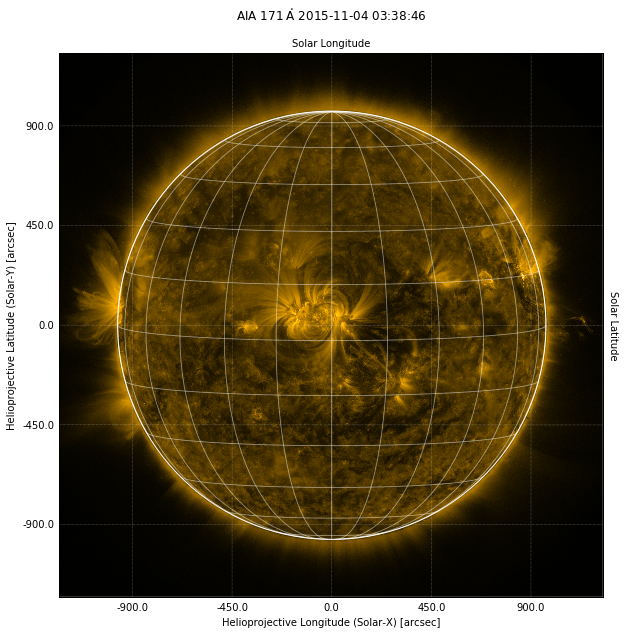

In [9]:
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(projection=aiamap)
aiamap.plot(axes=ax)
aiamap.draw_grid(axes=ax)
aiamap.draw_limb(axes=ax)
plt.show()

## Plot the MWA map

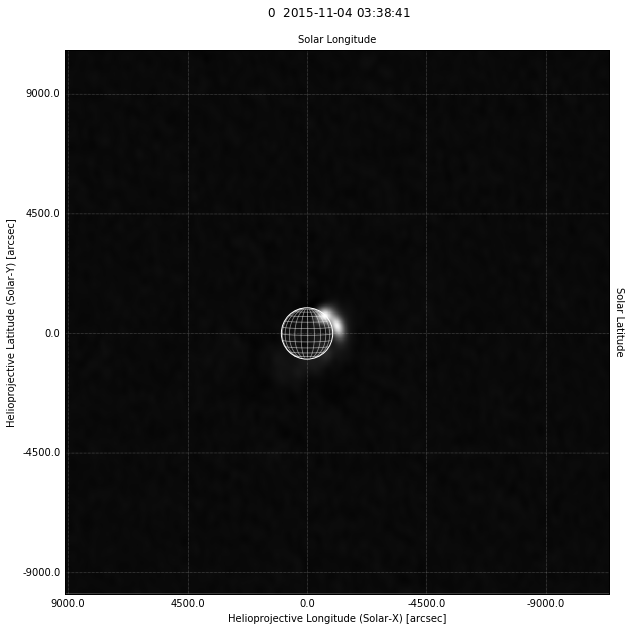

In [48]:
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(projection=mwamap)
mwamap.plot(axes=ax)
mwamap.draw_grid(axes=ax)
mwamap.draw_limb(axes=ax)
plt.show()

## Supposedly de-rotated MWA map

In [54]:
mwamap2 = mwamap.rotate(rmatrix=np.linalg.inv(aiamap.rotation_matrix),
                        recenter=True, order=3, scale=(mwamap.scale[0]/aiamap.scale[0]/10))
mwamap2 = mwamap.rotate(scale=(mwamap.scale[0]/aiamap.scale[0]/10))

## Plot the de-rotated map

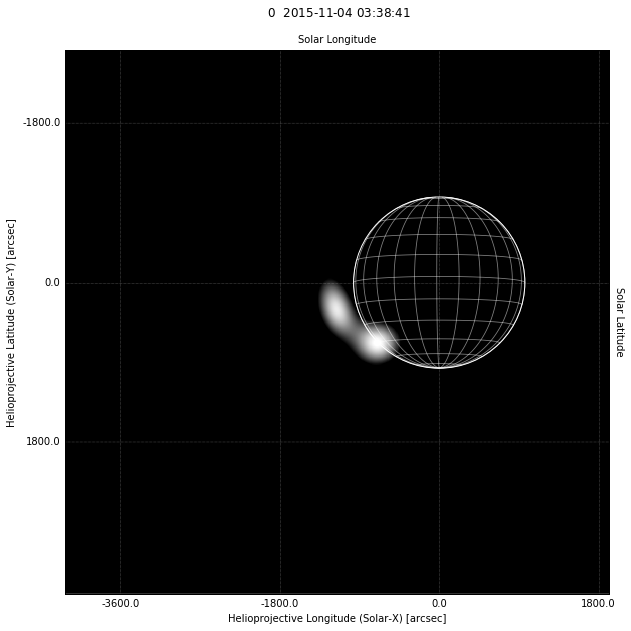

In [56]:
#Plot the de-rotated map
fig = plt.figure(figsize=(10,10))
mwamap2.plot()
mwamap2.draw_grid()
mwamap2.draw_limb()
plt.show()

## Create a composite AIA-MWA map for overlaying observations; plot

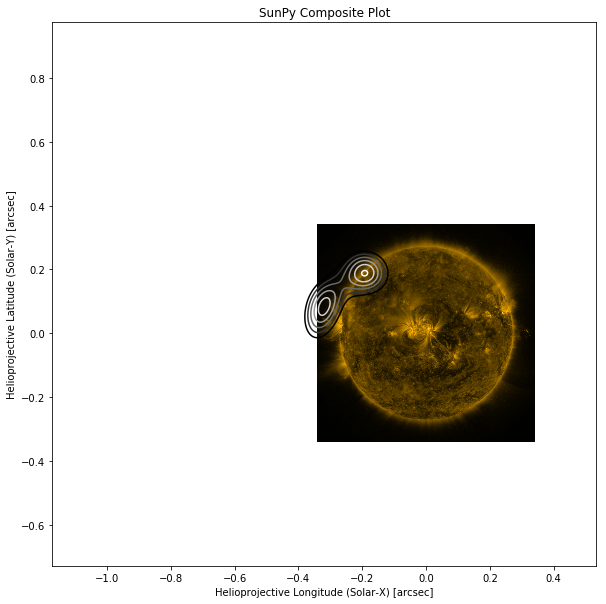

In [58]:
#Create a composite map for overlaying the radio observations on AIA image
mymaps = Map(aiamap,composite=True)
#Add the de-rotated map
mymaps.add_map(mwamap2)
mymaps.set_levels(1, [50, 60, 70, 80, 90,99], percent = True)
#Plot the composite map
fig = plt.figure(figsize=(10,10))
mymaps.plot()
plt.show()